In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
f_location = "https://drive.google.com/file/d/1unU1zt7a2H5KdifAFFQVuwHQtjsbi36B/view?usp=sharing"
data = pd.read_csv('https://drive.google.com/uc?export=download&id=' + f_location.split('/')[-2]) #Convert to pandas DataFrames

In [ ]:
# Define the calculate_gpa function
def calculate_gpa(row):
    grade_points = {
        # 'A+': 4.0, 'A': 4.0, 'A-': 3.7,
        # 'B+': 3.3, 'B': 3.0, 'B-': 2.7,
        # 'C+': 2.3, 'C': 2.0, 'C-': 1.7,
        # 'D+': 1.3, 'D': 1.0, 'D-': 0.7,
        # 'F': 0.0
        'A+': 4.00, 'A': 4.00, 'A-': 3.67,
        'B+': 3.33, 'B': 3.00, 'B-': 2.67,
        'C+': 2.33, 'C': 2.00, 'C-': 1.67,
        'D+': 1.33, 'D': 1.00, 'D-': 0.67,
        'F': 0.00
    }

    gpa_scale = {

}

    total_points = 0
    total_grades = 0

    for grade, points in grade_points.items():
        if grade in row:
            total_points += row[grade] * points
            total_grades += row[grade]
    if total_grades > 0:
        return total_points / total_grades
    else:
        return np.nan

# Load and preprocess the data
grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']
data['GPA'] = data.apply(calculate_gpa, axis=1)
processed_data = data.drop(columns=grade_columns).dropna(subset=['GPA'])
print(processed_data.head())

   Year    Term YearTerm Subject  Number                 Course Title  \
0  2023  Spring  2023-sp     ABE     141   ABE Principles: Biological   
1  2023  Spring  2023-sp     ABE     152  Water in Global Environment   
2  2023  Spring  2023-sp     ABE     232   Context Intl Interventions   
3  2023  Spring  2023-sp     ABE     425    Engrg Measurement Systems   
4  2023  Spring  2023-sp     ABE     457      NPS Pollution Processes   

  Sched Type  Primary Instructor       GPA  
0        LEC  Leonelli, Laurie B  3.100000  
1        ONL  Kalita, Prasanta K  3.778646  
2        OLC   Witmer, Ann-Perry  3.777778  
3        LCD       Grift, Tony E  3.941667  
4        LCD    Bhattarai, Rabin  3.763636  


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = data[['Year','Number']].values  # Year Feature and course number
target = data['GPA'].values


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# scale the data using MinMaxScaler, the purpose of this is to scale the data to be between 0 and 1
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape input data to be 3D for RNN [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# RNN building
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])


# adam optimizer, you can try adamw or sgd (need import)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, validation_data=(X_test_scaled, y_test_scaled))

loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss: {loss}, Mean Absolute Error: {mae}")

y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

for i in range(5):
    print(f"Predicted GPA: {y_pred[i][0]:.2f}, Actual GPA: {y_test[i]:.2f}")

accuracy = 1 - mean_absolute_error(y_test, y_pred) / np.mean(y_test)
print(f"Model Accuracy: {accuracy:.2f}")


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0749 - mae: 0.2058 - val_loss: 0.0256 - val_mae: 0.1302
Epoch 2/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0315 - mae: 0.1435 - val_loss: 0.0235 - val_mae: 0.1248
Epoch 3/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0287 - mae: 0.1374 - val_loss: 0.0236 - val_mae: 0.1251
Epoch 4/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0288 - mae: 0.1378 - val_loss: 0.0236 - val_mae: 0.1238
Epoch 5/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0278 - mae: 0.1349 - val_loss: 0.0236 - val_mae: 0.1250
Epoch 6/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - mae: 0.1321 - val_loss: 0.0239 - val_mae: 0.1262
Epoch 7/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0272 - mae: 0.1332 - val_loss: 0.0235 - val_mae: 0.1239
Epoch 8/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0265 - mae: 0.1316 - val_loss: 0.0234 - val_mae: 0.1237
Epoch 9/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss:

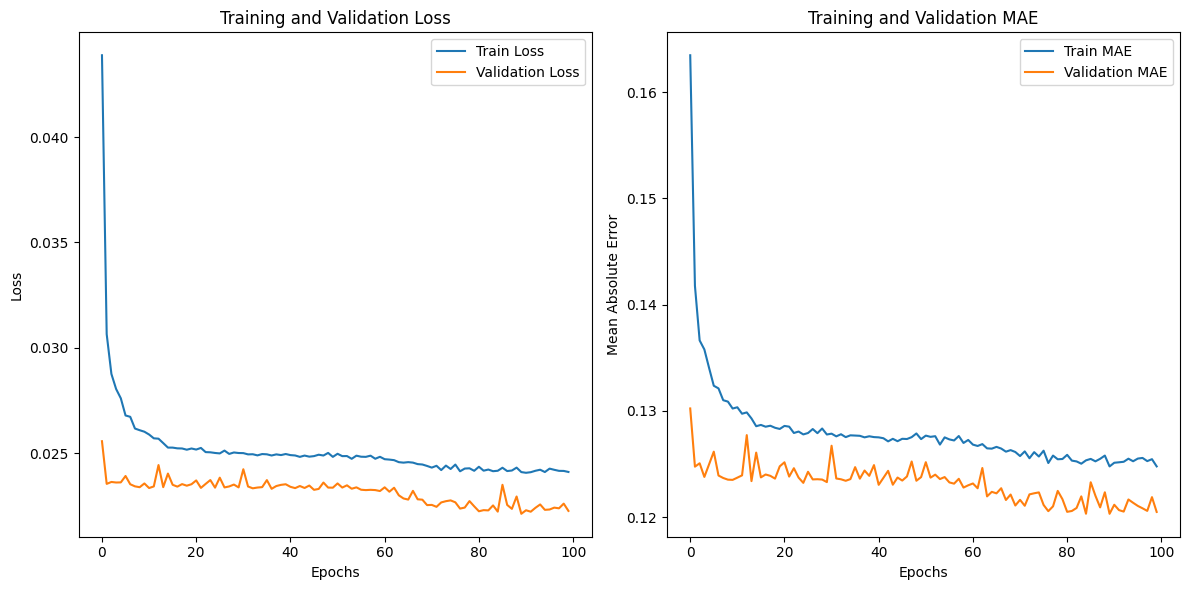

In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

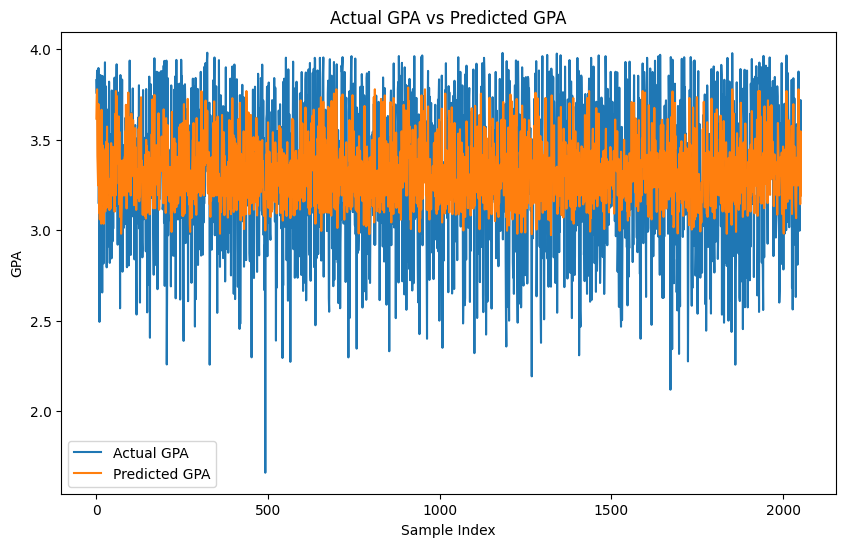

In [ ]:
# Plot the predicted GPA vs actual GPA
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual GPA')
plt.plot(y_pred, label='Predicted GPA')
plt.xlabel('Sample Index')
plt.ylabel('GPA')
plt.title('Actual GPA vs Predicted GPA')
plt.legend()
plt.show()